In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from glob import glob 
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1
from copy import deepcopy
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
files = glob('/Users/rri38/Documents/work/code/SynDiff/development/data/*.fits')

hdu = fits.open(files[0])
wcs = WCS(hdu[1])
data = hdu[1].data

Set MJD-END to 58843.733690 from DATE-END'. [astropy.wcs.wcs]


In [3]:
ra = hdu[1].header['CRVAL1']
dec = hdu[1].header['CRVAL2']

pix_scale = 21.0
c1 = SkyCoord(ra, dec, frame='icrs', unit='deg')
catalog = "I/355/gaiadr3"
result = Vizier.query_region(c1, catalog=[catalog],
                                     radius=Angle(2048 * pix_scale, "arcsec"),column_filters={'Gmag':'<17'})
result = result[catalog].to_pandas()
x,y = wcs.all_world2pix(result.RA_ICRS,result.DE_ICRS,0)
ind = (x > 0) & (x < data.shape[1]) & (y > 0) & (y < data.shape[0])
result['x'] = x; result['y'] = y
gaia = deepcopy(result.iloc[ind])

catalog = "II/349/ps1"
result = Vizier.query_region(c1, catalog=[catalog],
                             radius=Angle(2048 * pix_scale, "arcsec"),column_filters={'imag':'<18'})
result = result[catalog].to_pandas()
x,y = wcs.all_world2pix(result.RAJ2000,result.DEJ2000,0)
ind = (x > 0) & (x < data.shape[1]) & (y > 0) & (y < data.shape[0])
result['x'] = x; result['y'] = y
ps1 = deepcopy(result.iloc[ind])
ps1.to_csv('data/ps1_test_region.csv',index=False)
gaia.to_csv('data/gaia_test_region.csv',index=False)

In [4]:
ps1 = pd.read_csv('data/ps1_test_region.csv')
ind = (ps1.x.values > 3) & (ps1.x.values < data.shape[1]-3) & (ps1.y.values > 3) & (ps1.y.values < data.shape[0]-3)
ps1 = ps1.iloc[ind]
gaia = pd.read_csv('data/gaia_test_region.csv')
ind = (gaia.x.values > 3) & (gaia.x.values < data.shape[1]-3) & (gaia.y.values > 3) & (gaia.y.values < data.shape[0]-3)
gaia = gaia.iloc[ind]

In [5]:
def PS1_tess_comp(ps1):
    cg = 0
    cr = 0.238#0.23482658 old values
    ci = 0.344#0.35265516
    cz = 0.283#0.27569384
    cy = 0.135#0.13800082
    cp = 0#0.00067772
    fit = ((cg*10**((ps1['gmag']-25)/-2.5) + cr*10**((ps1['rmag']-25)/-2.5) + ci*10**((ps1['imag']-25)/-2.5) + 
            cz*10**((ps1['zmag']-25)/-2.5) + cy*10**((ps1['ymag']-25)/-2.5))*(10**((ps1['gmag']-25)/-2.5)/10**((ps1['imag']-25)/-2.5))**cp)
    fit[~np.isfinite(fit)] = 0
    fit = -2.5*np.log10(fit) + 25
    return fit 

In [6]:
ps1['TESS'] = PS1_tess_comp(ps1)

/Users/rri38/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
def cross_match(obs_cat, viz_cat):
    radius_threshold = 0.5*u.arcsec
    coords_viz = SkyCoord(ra=viz_cat.RA_ICRS, dec=viz_cat.DE_ICRS, unit='deg')
    coords_obs = SkyCoord(ra=obs_cat.RAJ2000, dec=obs_cat.DEJ2000, unit='deg')
    idx, d2d, d3d = coords_viz.match_to_catalog_3d(coords_obs)
    sep_constraint = d2d <= radius_threshold
    # Get entries in cat_ref with a match
    viz_matched = viz_cat[sep_constraint]
    # Get matched entries in cat_sci
    obs_matched = obs_cat.iloc[idx[sep_constraint]]
    # re-index to match two dfs
    viz_matched = viz_matched.reset_index(drop=True)
    obs_matched = obs_matched.reset_index(drop=True)
    return obs_matched, viz_matched

In [8]:
ps1m, gaiam = cross_match(ps1,gaia)

<IPython.core.display.Javascript object>


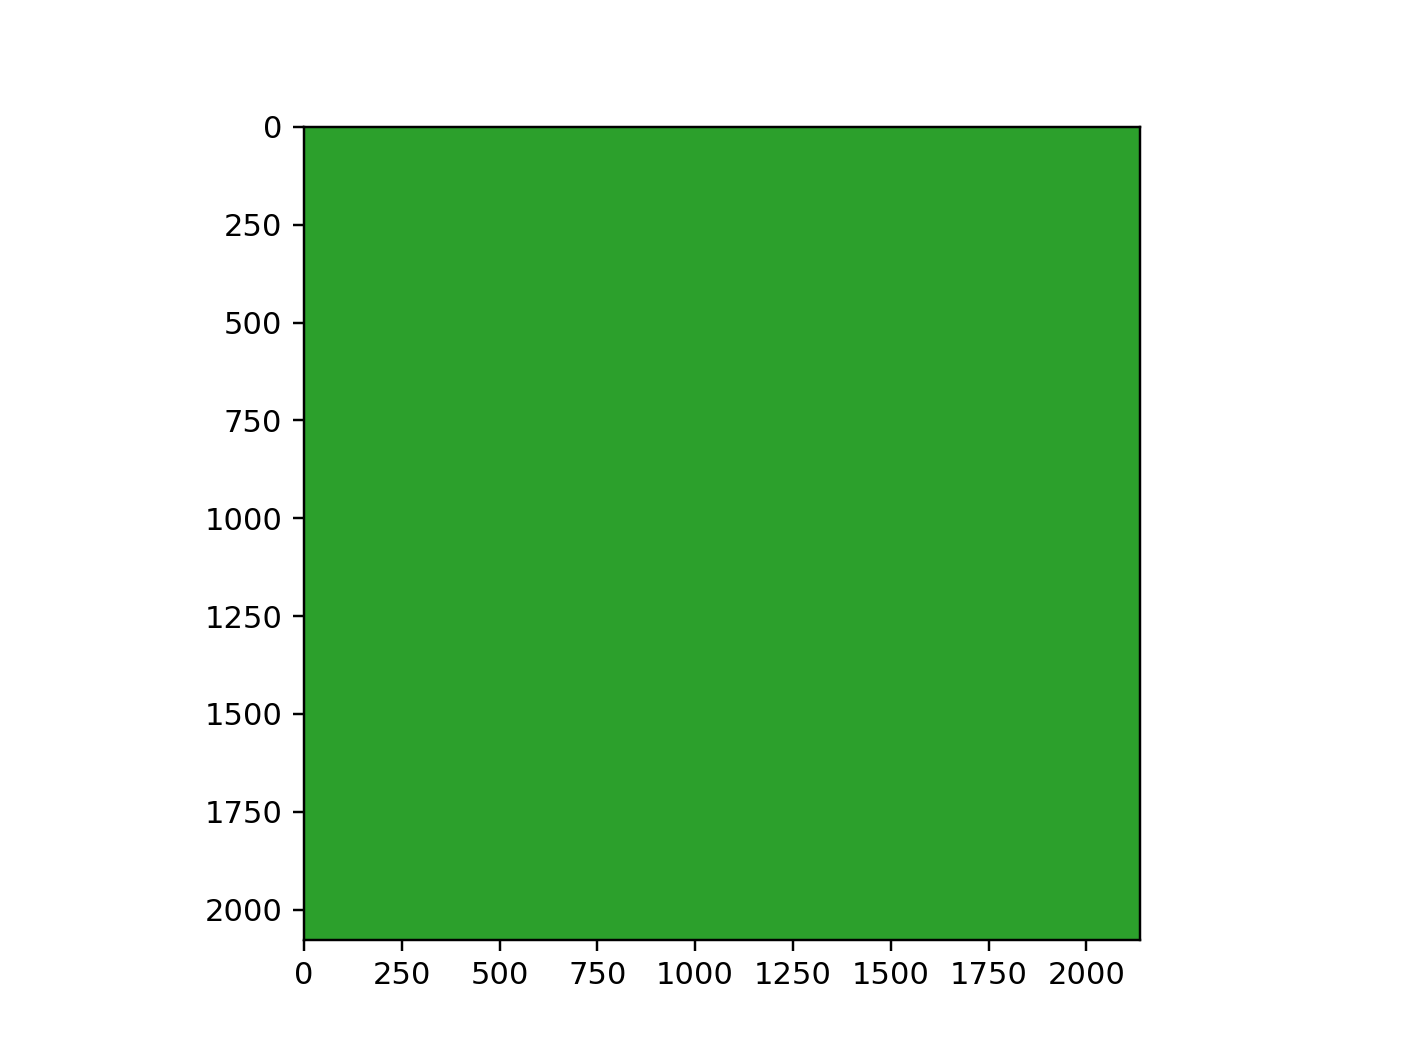

In [9]:
plt.figure()
plt.imshow(data,vmin=100,vmax=200)
plt.scatter(gaiam['x'],gaiam['y'],c='C1')
plt.scatter(ps1m['x'],ps1m['y'],c='C2',marker='x')

In [23]:
from photutils.aperture import RectangularAperture
from photutils.aperture import CircularAperture

In [24]:
pos = []
for i in range(len(gaiam)):
    pos += [(gaiam['x'].values[i], gaiam['y'].values[i])]

In [25]:
aper = RectangularAperture(pos, 3.0, 3.0)
caper = CircularAperture(pos, r=1.5)

In [26]:
from astropy.stats import sigma_clipped_stats

In [27]:
mean, med, std = sigma_clipped_stats(data,maxiters=20)

In [28]:
med

121.7596

In [29]:
from photutils.aperture import aperture_photometry
phot_table = aperture_photometry(data, aper)
cphot_table = aperture_photometry(data, caper)

In [30]:
smag = -2.5*np.log10(phot_table['aperture_sum'].value-9*med)

## PSF photom

In [31]:
from PRF import TESS_PRF
from tessreduce import par_psf_initialise,par_psf_flux
from joblib import Parallel, delayed

In [32]:
ps1m = ps1m.sort_values('imag')

In [33]:
ps1m.imag

45491      5.7630
59190      5.9790
6703       6.0310
157251     6.0470
72734      6.1061
           ...   
5442      17.4882
99592     17.5238
39375     17.5295
153146    17.5397
12528     17.7166
Name: imag, Length: 163486, dtype: float64

In [36]:
ypos = ps1m.y.values; xpos = ps1m.x.values
size = 5
inds = np.arange(10000)#len(xpos))
flux = Parallel(n_jobs=-1)(delayed(par_psf_initialise)(data,1,1,20,
                                                        ypos[i],xpos[i],size,
                                                        [xpos[i],ypos[i]],0,False,True) for i in inds)


In [38]:
-2.5*np.log10(flux)

array([-14.51076074, -14.31087578,   0.92316822, ...,  -9.53158   ,
        -8.12220656,  -8.17646969])

In [39]:
smag

array([        nan,         nan,         nan, ..., -4.9864782 ,
       -5.46513354, -5.88284837])

In [33]:
pos1 = np.array([ps1m['RAJ2000'].values,ps1m['DEJ2000'].values]).T.astype(float)
distance = 4*21 / 60**2 
tree = KDTree(pos1)
dist,ind = tree.query(pos1, k=5)
dist_ind = (dist > distance)[:,1]


'''dist = dist.flatten()

d_ind = np.where(dist < distance)[0]
min_dist = np.argmin(dist[d_ind])
d_ind = d_ind[min_dist]'''

'dist = dist.flatten()\n\nd_ind = np.where(dist < distance)[0]\nmin_dist = np.argmin(dist[d_ind])\nd_ind = d_ind[min_dist]'

<IPython.core.display.Javascript object>


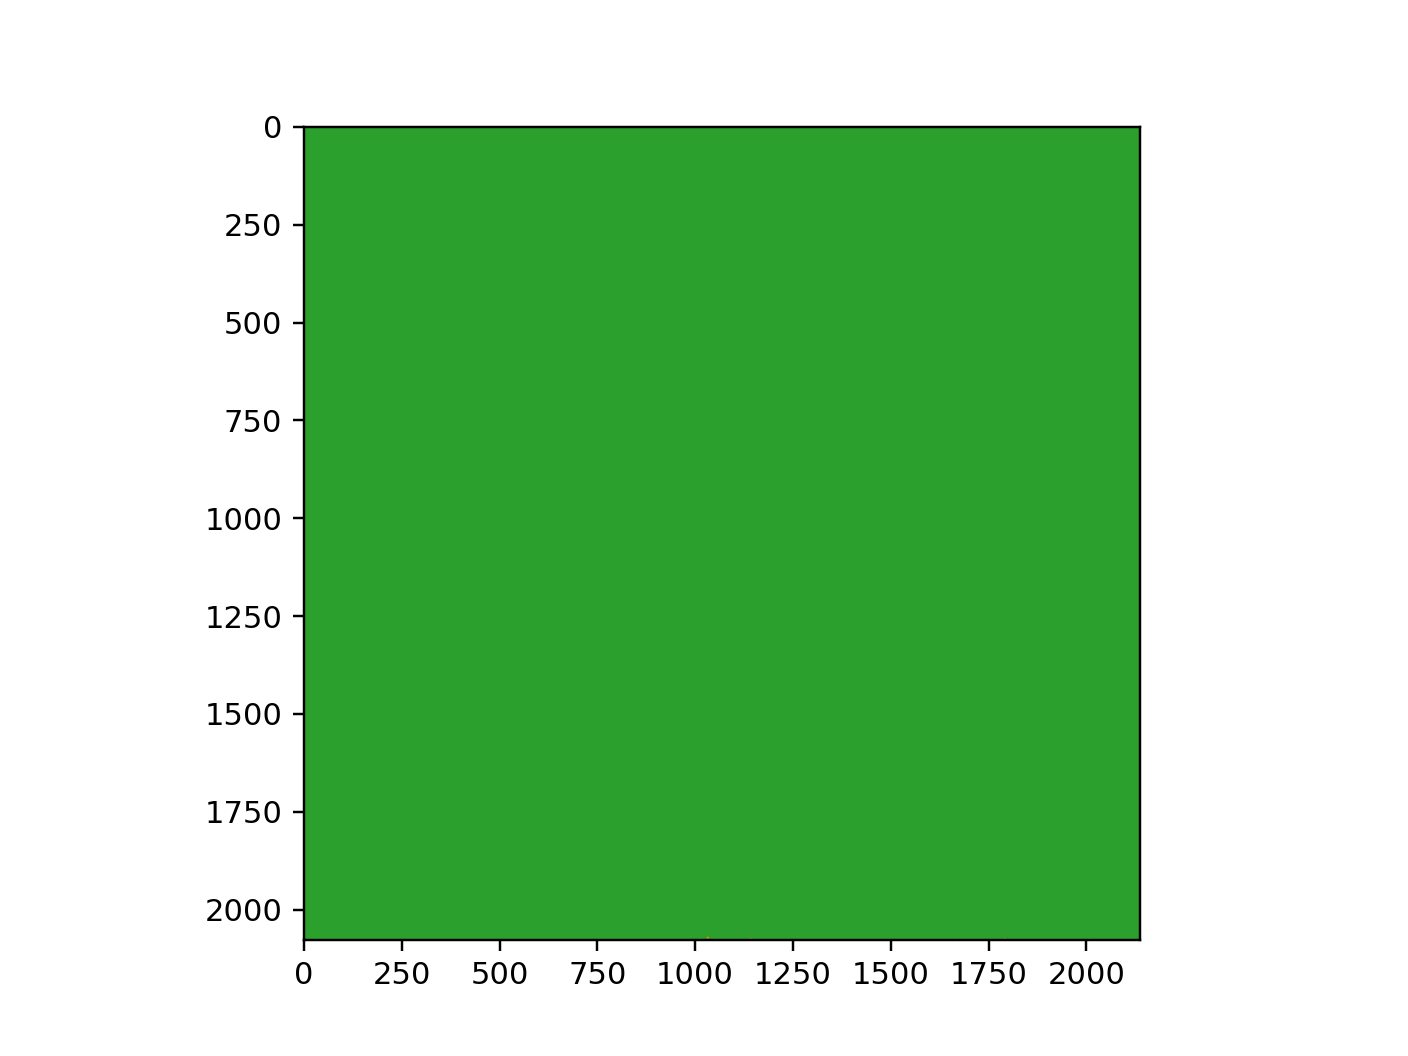

In [34]:
plt.figure()
plt.imshow(data,vmin=100,vmax=200)
plt.scatter(gaiam['x'].iloc[dist_ind],gaiam['y'].iloc[dist_ind],c='C1')
plt.scatter(ps1m['x'].iloc[dist_ind],ps1m['y'].iloc[dist_ind],c='C2',marker='x')

In [35]:
len(ps1m)

163486

In [36]:
ps1m = ps1m.iloc[dist_ind]
gaiam = gaiam.iloc[dist_ind]
smag = smag[dist_ind]

In [49]:
cut_mag = 14
ind = ps1m['TESS'].values < cut_mag
zp = np.nanmedian(ps1m['TESS'].values[ind]-smag[ind])

psfmag = -2.5*np.log10(flux)
zppsf = np.nanmedian(ps1m['TESS'].values[:10000]-psfmag)

In [62]:
m, med, std = sigma_clipped_stats(diff[ind]+zp)
cond = (abs(diff+zp)< (med) + 5*std) & ind

<IPython.core.display.Javascript object>


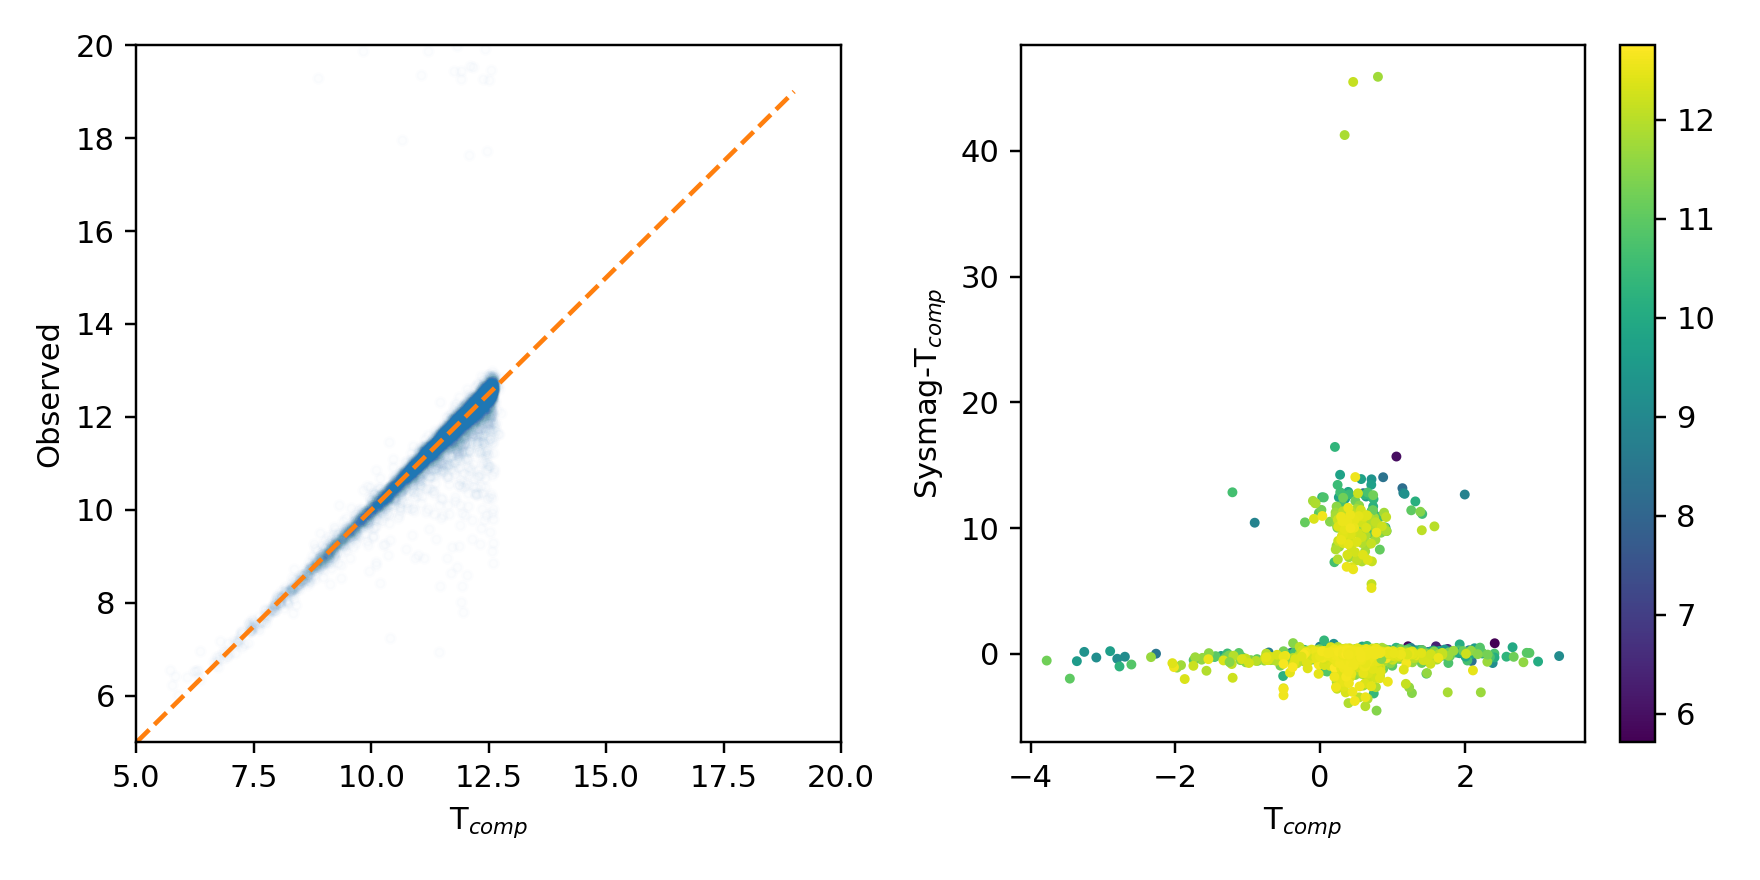

In [54]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(ps1m['TESS'].values[:10000],psfmag+zppsf,'.',alpha=0.01);
#plt.plot(gaiam['Gmag'].values,smag+zp,'.',alpha=0.1);
#plt.plot(ps1m['TESS'],-2.5*np.log10(cphot_table['aperture_sum'].value),'.',alpha=0.5);
#plt.axvline(cut_mag,ls=':',c='k')
plt.plot(np.arange(0,20),np.arange(0,20),'--')
plt.ylabel('Observed')
plt.xlabel(r'T$_{comp}$')
plt.ylim(5,20)
plt.xlim(5,20)

g_r = ps1m['gmag'] - ps1m['rmag']
diff = smag-ps1m['TESS'].values
color = ps1m['TESS'].values
plt.subplot(122)
plt.scatter(g_r[:10000],psfmag+zppsf-ps1m['TESS'].values[:10000],c=color[:10000],s=5);
#plt.plot(ps1m['TESS'],-2.5*np.log10(cphot_table['aperture_sum'].value),'.',alpha=0.5);
plt.ylabel(r'Sysmag-T$_{comp}$')
plt.xlabel(r'T$_{comp}$')
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


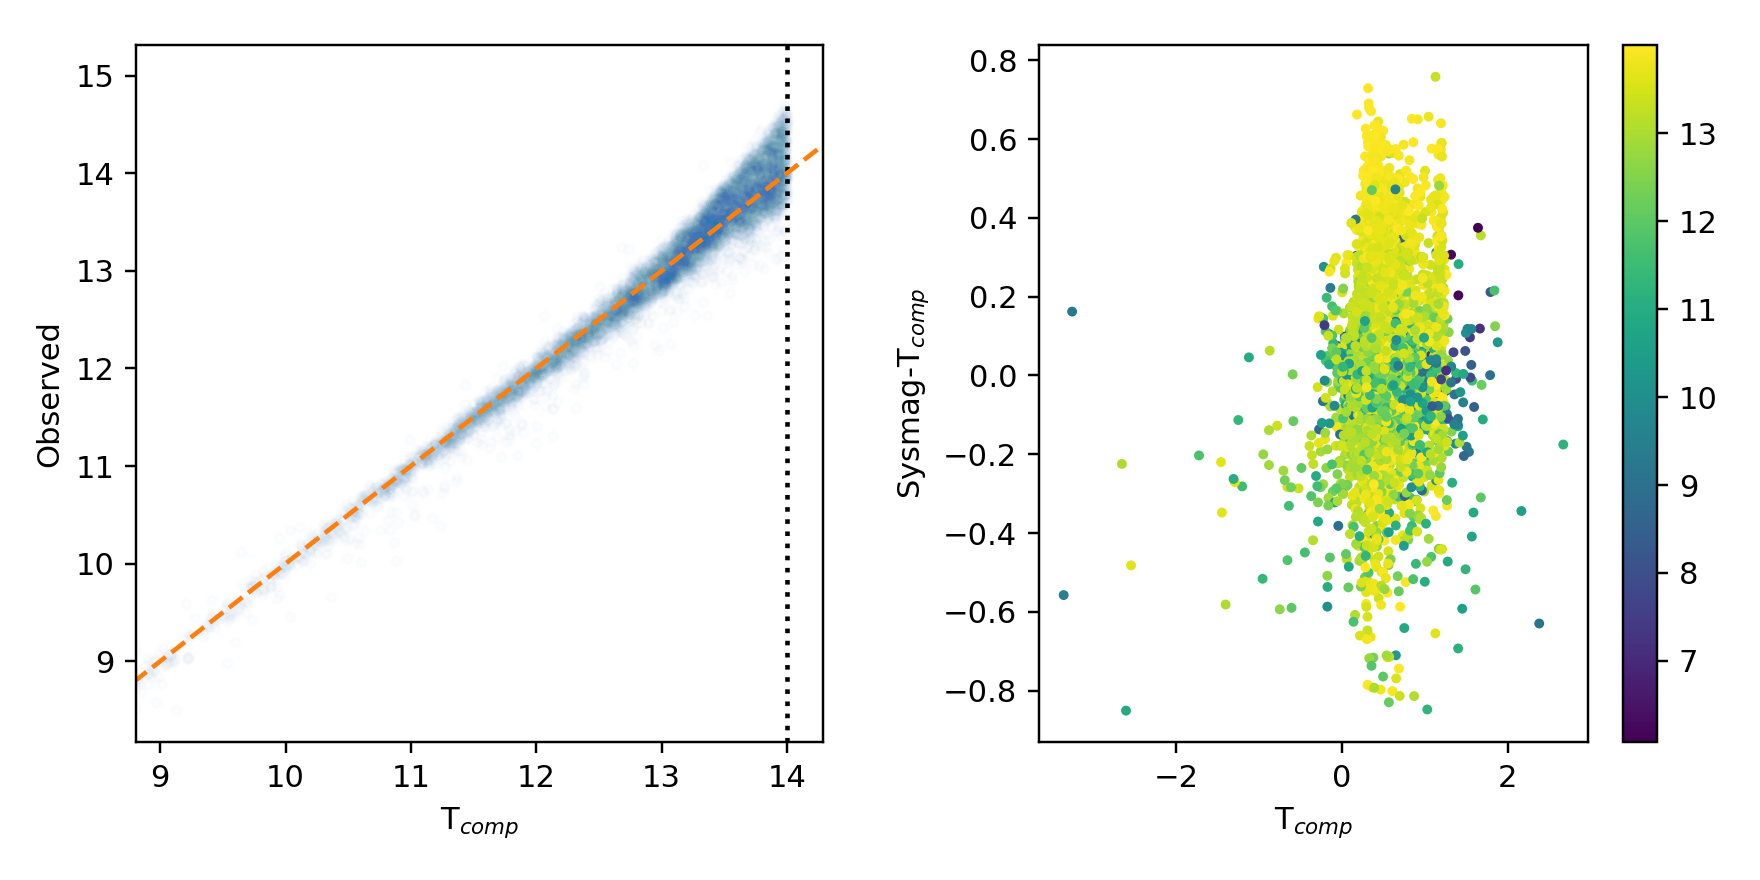

In [63]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(ps1m['TESS'].values[cond],smag[cond]+zp,'.',alpha=0.01);
#plt.plot(gaiam['Gmag'].values,smag+zp,'.',alpha=0.1);
#plt.plot(ps1m['TESS'],-2.5*np.log10(cphot_table['aperture_sum'].value),'.',alpha=0.5);
plt.axvline(cut_mag,ls=':',c='k')
plt.plot(np.arange(0,20),np.arange(0,20),'--')
plt.ylabel('Observed')
plt.xlabel(r'T$_{comp}$')
plt.ylim(5,20)
plt.xlim(5,20)

g_r = ps1m['gmag'] - ps1m['rmag']
diff = smag-ps1m['TESS'].values
color = ps1m['TESS'].values
plt.subplot(122)
plt.scatter(g_r[cond],diff[cond]+zp,c=color[cond],s=5);
#plt.plot(ps1m['TESS'],-2.5*np.log10(cphot_table['aperture_sum'].value),'.',alpha=0.5);
plt.ylabel(r'Sysmag-T$_{comp}$')
plt.xlabel(r'T$_{comp}$')
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


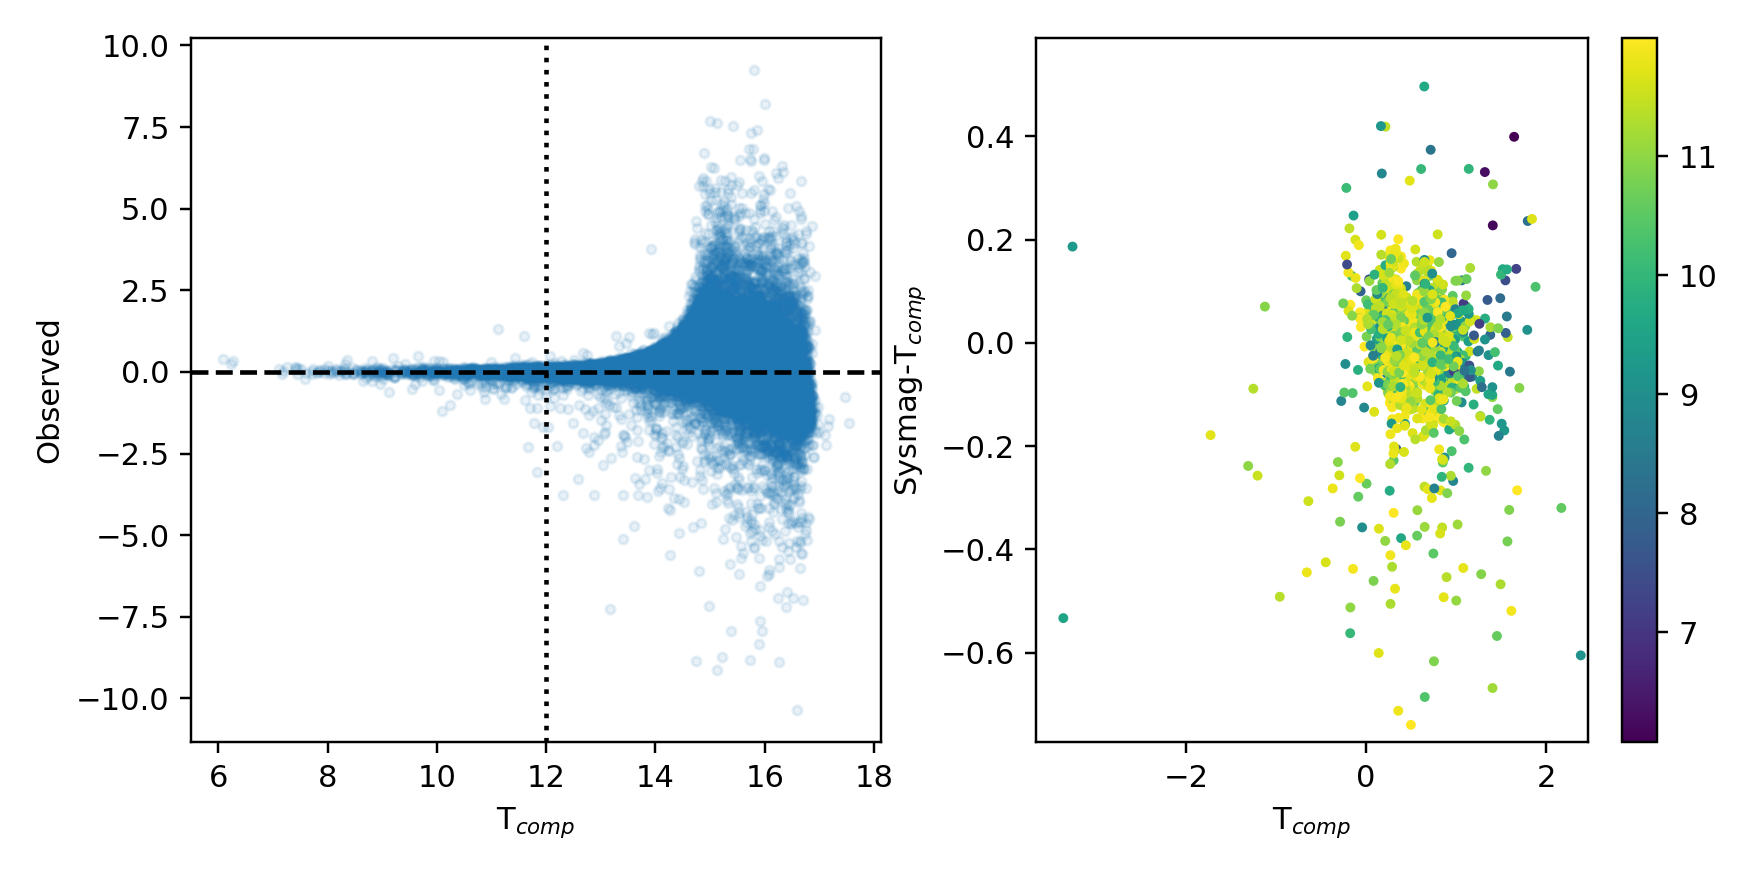

In [88]:
g_r = ps1m['gmag'] - ps1m['rmag']
diff = smag-ps1m['TESS'].values
color = ps1m['TESS'].values

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(ps1m['TESS'].values,diff+zp,'.',alpha=0.1);
#plt.plot(ps1m['TESS'],-2.5*np.log10(cphot_table['aperture_sum'].value),'.',alpha=0.5);
#plt.plot(np.arange(0,20),np.arange(0,20),'--')
plt.axvline(cut_mag,ls=':',c='k')
plt.axhline(0,ls='--',c='k')
plt.ylabel('Observed')
plt.xlabel(r'T$_{comp}$')
#plt.ylim(5,20)
#plt.xlim(5,20)


plt.subplot(122)
plt.scatter(g_r[ind],diff[ind]+zp,c=color[ind],s=5);
#plt.plot(ps1m['TESS'],-2.5*np.log10(cphot_table['aperture_sum'].value),'.',alpha=0.5);
plt.ylabel(r'Sysmag-T$_{comp}$')
plt.xlabel(r'T$_{comp}$')
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


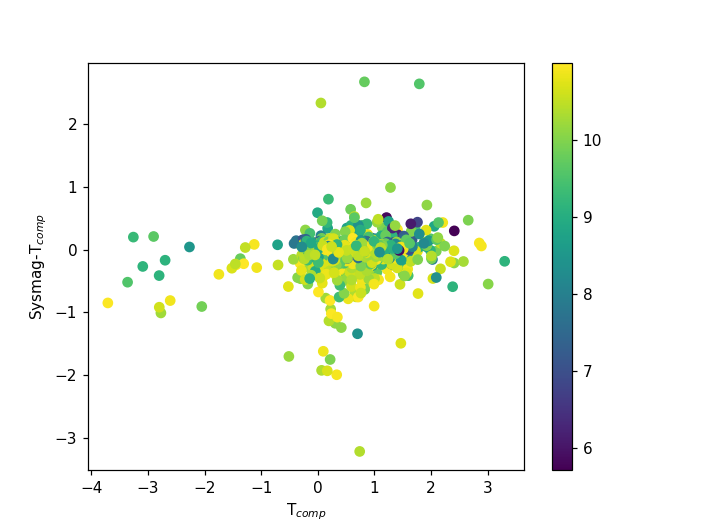

In [275]:
ps1m[ind].gmag

0         11.347
14        11.958
26        11.090
126       11.059
180       10.236
           ...  
164092    11.116
164145    10.883
164258    10.357
164366    11.793
164406    12.371
Name: gmag, Length: 2321, dtype: float64

In [ ]:
c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')

In [ ]:
def Get_Catalogue(tpf, Catalog = 'gaia'):
    """
    Get the coordinates and mag of all sources in the field of view from a specified catalogue.


    I/347/gaia2dis   Distances to 1.33 billion stars in Gaia DR2 (Bailer-Jones+, 2018)

    -------
    Inputs-
    -------
        tpf 				class 	target pixel file lightkurve class
        Catalogue 			str 	Permitted options: 'gaia', 'dist', 'ps1'

    --------
    Outputs-
    --------
        coords 	array	coordinates of sources
        Gmag 	array 	Gmags of sources
    """
    c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
    # Use pixel scale for query size	
    pix_scale = 21.0
    # We are querying with a diameter as the radius, overfilling by 2x.
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    if Catalog == 'gaia':
        catalog = "I/345/gaia2"
    elif Catalog == 'dist':
        catalog = "I/350/gaiaedr3"
    elif Catalog == 'ps1':
        catalog = "II/349/ps1"
    elif Catalog == 'skymapper':
        catalog = 'II/358/smss'
    else:
        raise ValueError(f"{catalog} not recognised as a catalog. Available options: 'gaia', 'dist','ps1'")
    if Catalog == 'gaia':
        result = Vizier.query_region(c1, catalog=[catalog],
                                     radius=Angle(np.max(tpf.shape[1:]) * pix_scale + 60, "arcsec"),column_filters={'Gmag':'<19'})
    else:
        result = Vizier.query_region(c1, catalog=[catalog],
                                     radius=Angle(np.max(tpf.shape[1:]) * pix_scale + 60, "arcsec"))

    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    #too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise no_targets_found_message
    result = result[catalog].to_pandas()

    return result 